In [2]:
library(ggplot2)
library(dplyr)
library(PhIPData)
library(reshape2)

In [3]:
### parameters
base_dir='../data-final/virscan_momi_all_2024-12-23/'
multiple_plates=TRUE

In [ ]:
###############################################

In [4]:
phip_data <- readRDS(paste0(base_dir,"rds_data/PhIPData.rds"))



In [5]:
# str(cnt)
# str(cpm)
# str(qc)
phip_data

class: PhIPData 
dim: 128257 779 
metadata(2): date_run reads_per_sample
assays(6): counts logfc ... edgeR_logpval edgeR_hits
rownames(128257): 0 1 ... 128255 128256
rowData names(26): peptide_id Unnamed..0 ... start peptide
colnames(779): 0 1 ... 777 778
colData names(83): sample_id sample_name ... percent_peptides_detected
  percent_peptides_between_10_and_100
beads-only name(33): beads

In [6]:
phip_data@colData

DataFrame with 779 rows and 83 columns
    sample_id    sample_name      sample       Plate       index Well.Position
    <integer>    <character> <character> <character> <character>   <character>
0           0 3001 MBPLAV1A1    E1-p123b       p123b      IDX049            E1
1           1 3001 MBPLAV1A1      A10-p3          p3      IDX010           A10
2           2 3001 MBPLAV1A1      E10-p3          p3      IDX058           E10
3           3 3001 MBPLAV1A1    A1-p123b       p123b      IDX001            A1
4           4 3002 MBPLAV1A1      E12-p2          p2      IDX156           E12
...       ...            ...         ...         ...         ...           ...
774       774  Y-MGH-9-115 M      G11-p6          p6      IDX083           G11
775       775  Y-MGH-9-171 M      C10-p7          p7      IDX130           C10
776       776  Y-MGH-9-171 M      G10-p7          p7      IDX178           G10
777       777  Y-MGH-9-456 M      C11-p7          p7      IDX131           C11
778       778

In [1]:
# with(data.frame(phip_data@colData),
#    table( Plate,sample_name )
# )

In [8]:
head(assays(phip_data)[['counts']])
assays(phip_data)


,0,1,2,3,4,5,6,7,8,9,...,769,770,771,772,773,774,775,776,777,778
0,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,4,6,17,0,13,3,14,16,6,1,...,51,14,29,7,10,10,3,1,9,2
2,0,0,0,0,1,0,0,0,0,0,...,1,2,0,0,11,0,3,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,0,2,0,0,1
4,2,8,0,1,9,0,17,10,13,0,...,20,35,23,5,22,75,5,19,2,7
5,0,6,1,1,12,2,6,7,4,0,...,29,15,13,8,13,81,5,5,2,2


List of length 6
names(6): counts logfc prob edgeR_logfc edgeR_logpval edgeR_hits

In [9]:
for(n in names(assays(phip_data))){
    print(n)
    head(tmp<-assays(phip_data)[[n]])
    print(paste('missing:', signif(sum(is.na(tmp))/prod(dim(tmp)),3)*100,'%'))
}

[1] "counts"
[1] "missing: 0 %"
[1] "logfc"
[1] "missing: 100 %"
[1] "prob"
[1] "missing: 100 %"
[1] "edgeR_logfc"
[1] "missing: 4.24 %"
[1] "edgeR_logpval"
[1] "missing: 4.24 %"
[1] "edgeR_hits"
[1] "missing: 4.24 %"


# add missing data

In [10]:
cpm = data.table::fread(paste0(base_dir,'wide_data/data_cpm.csv.gz'),header = T)[,-1]
ench = data.table::fread(paste0(base_dir,'wide_data/data_enrichment.csv.gz'),header = T)[,-1]
z = data.table::fread(paste0(base_dir,'wide_data/data_zscore.csv.gz'),header = T)[,-1]
count = data.table::fread(paste0(base_dir,'wide_data/data_counts.csv.gz'),header = T)[,-1]


In [11]:
prob = as.matrix(z)
for(i in 1:ncol(z)){
    prob[,i] = pnorm(as.numeric(unlist(prob[,i])) , lower.tail = F ) 
}

In [ ]:
# head(as.matrix(count))

In [12]:
assays(phip_data)[['cpm']] = as.matrix(cpm)
assays(phip_data)[['logfc']] = as.matrix(log(ench))
# assays(phip_data)[['z']] = as.matrix(z)
assays(phip_data)[['prob']] = as.matrix(prob)



# check distributions

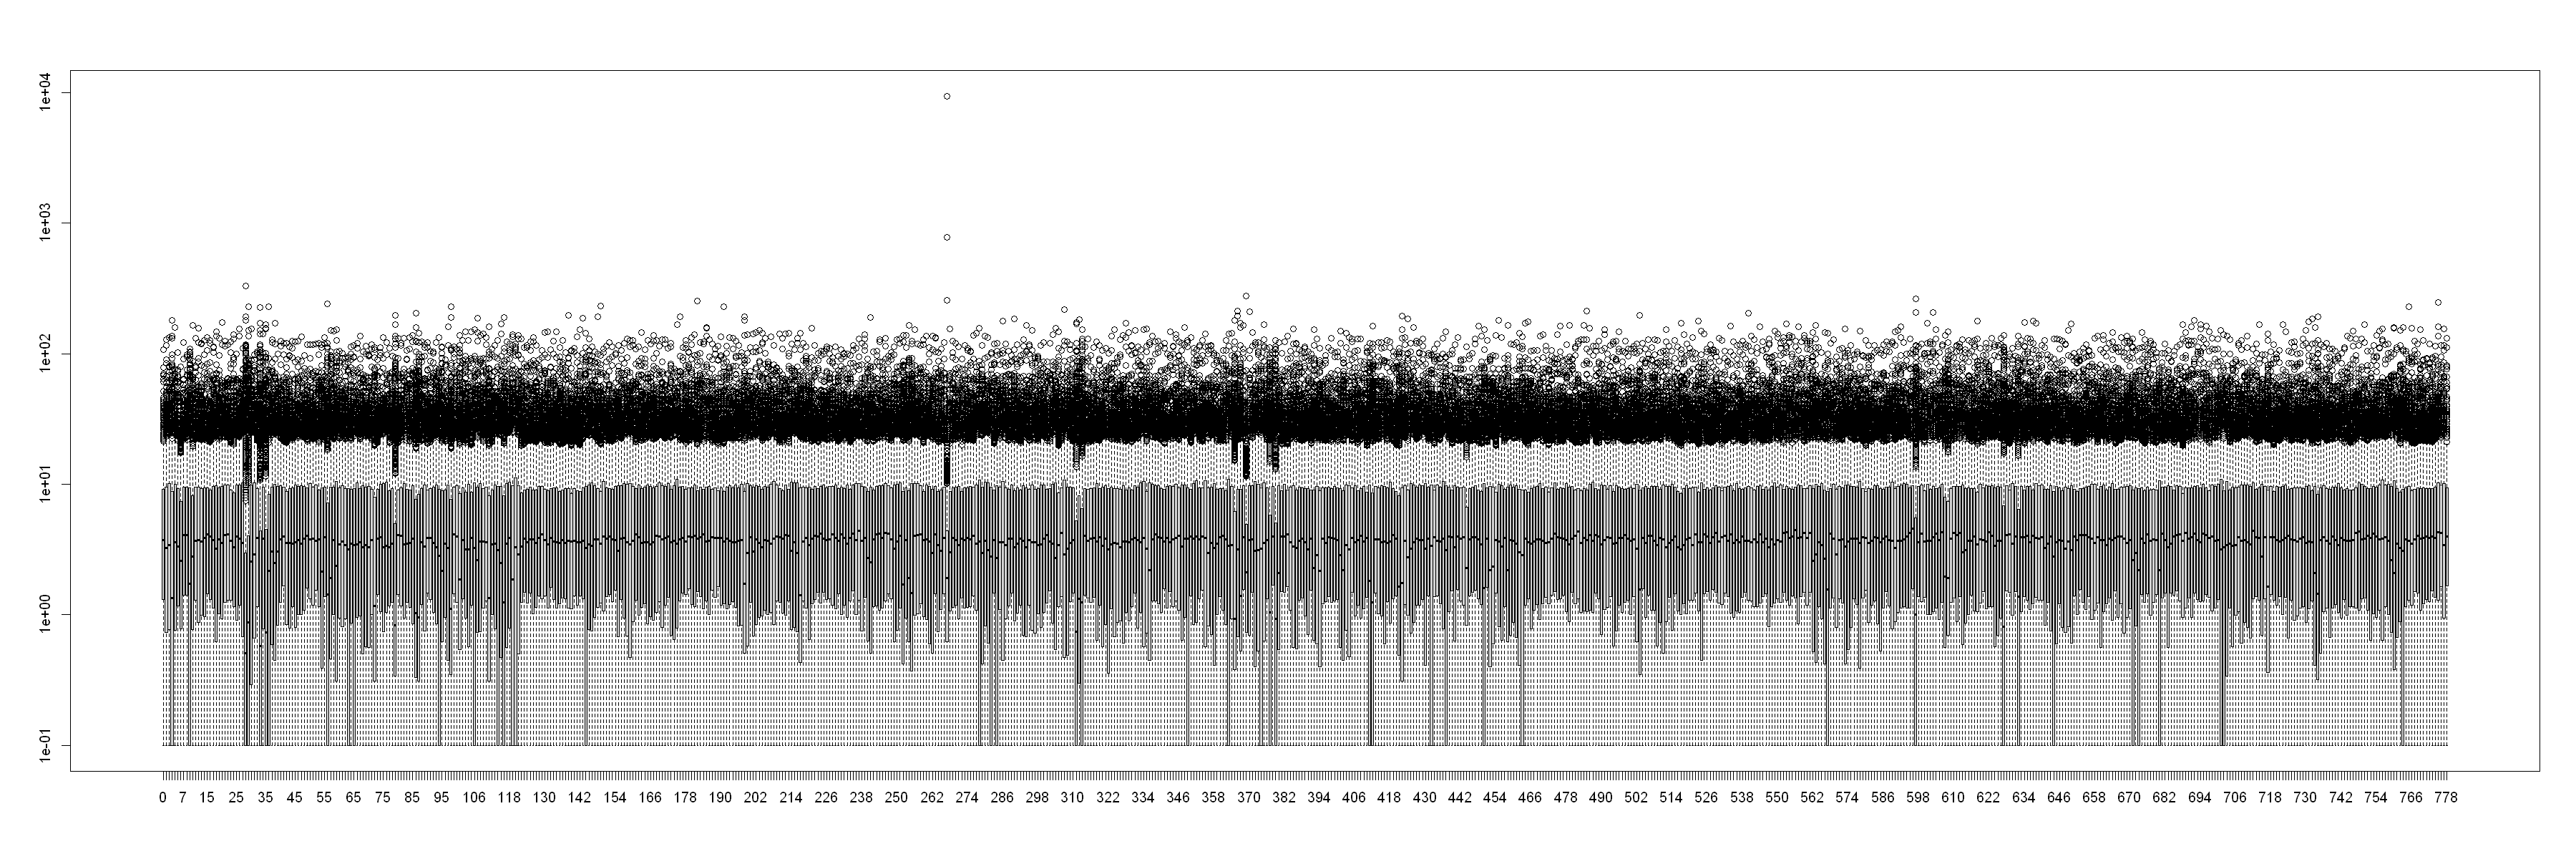

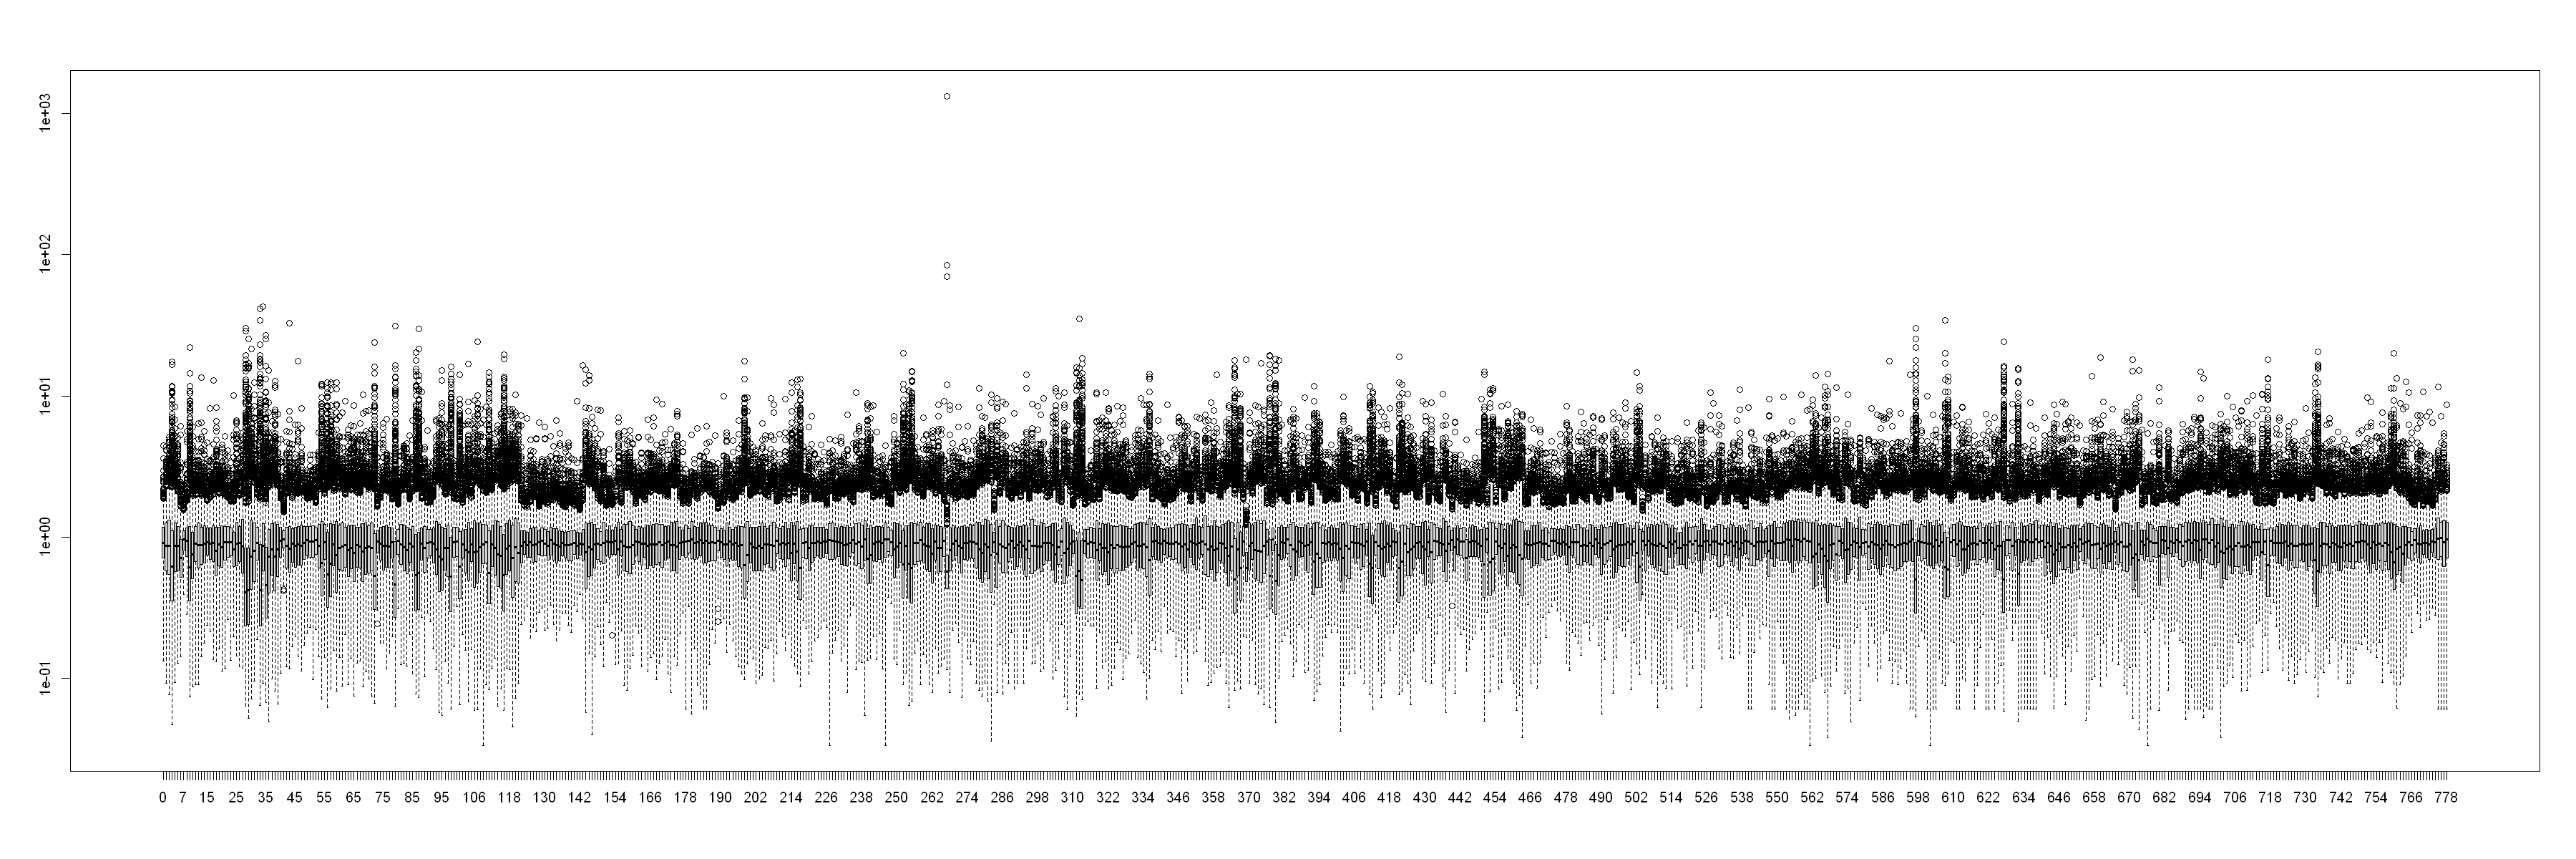

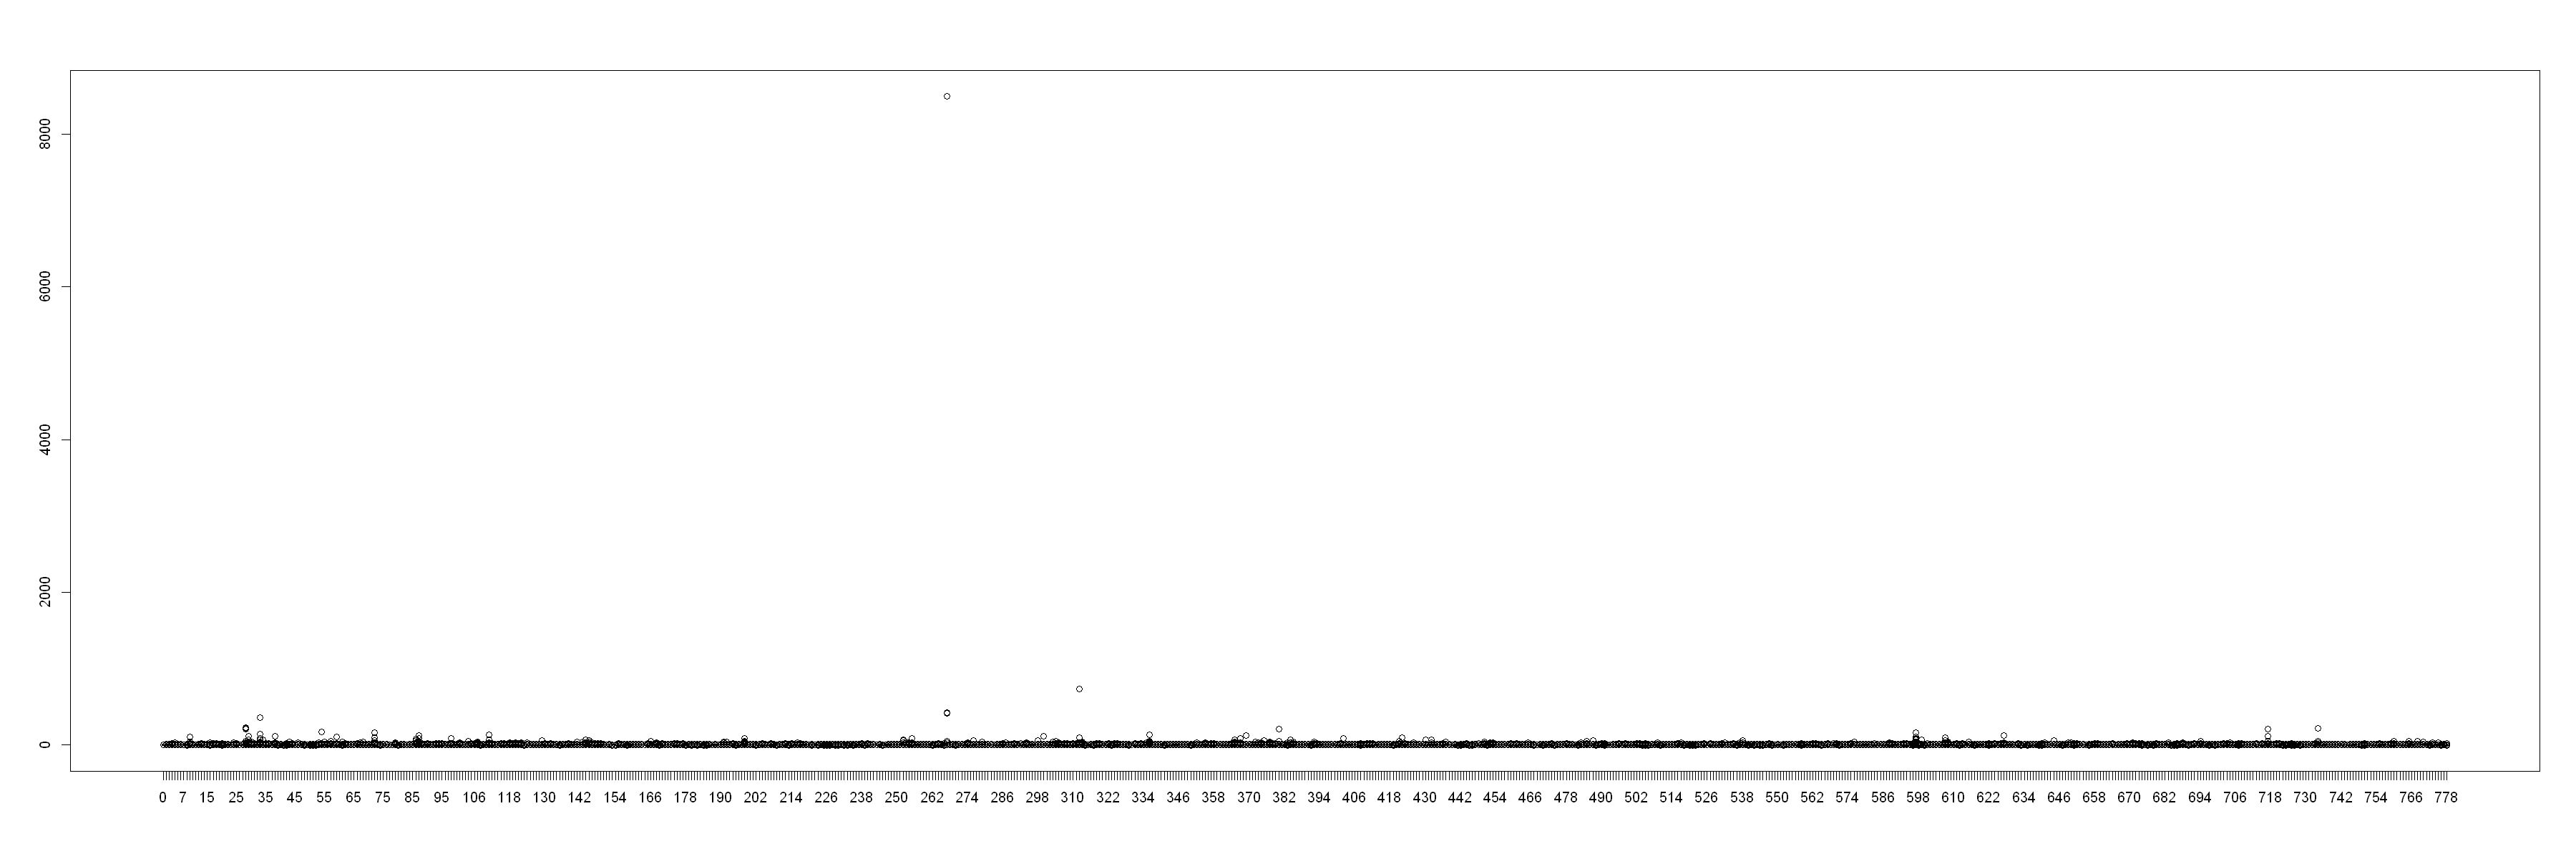

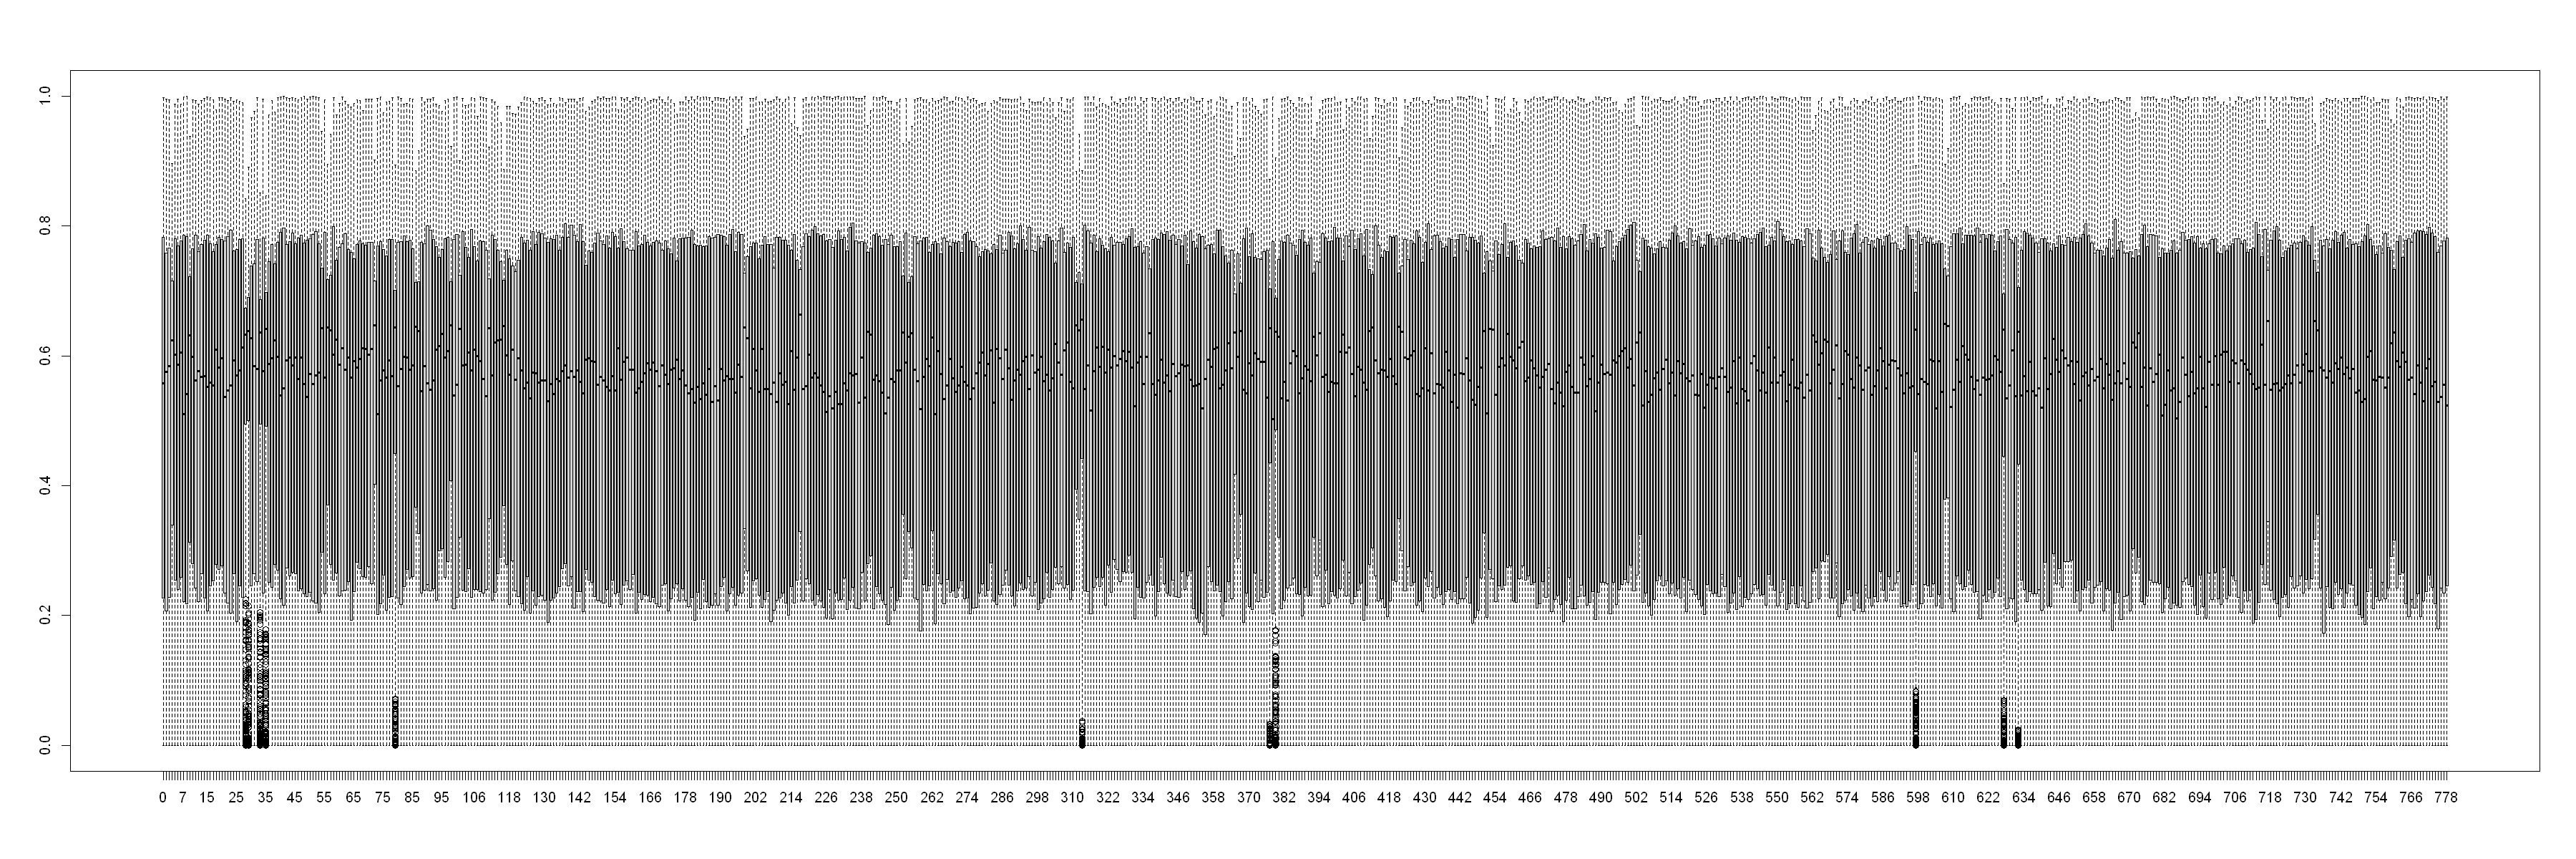

In [13]:
options( repr.plot.width=30,repr.plot.height=10)

idx= idx<-sample(1:nrow(cpm),1000)

boxplot( cpm[idx,]+.1,log = 'y')
boxplot( ench[idx,],log='y') # lfc?
boxplot( z[idx,])
# sum(ench<=0)

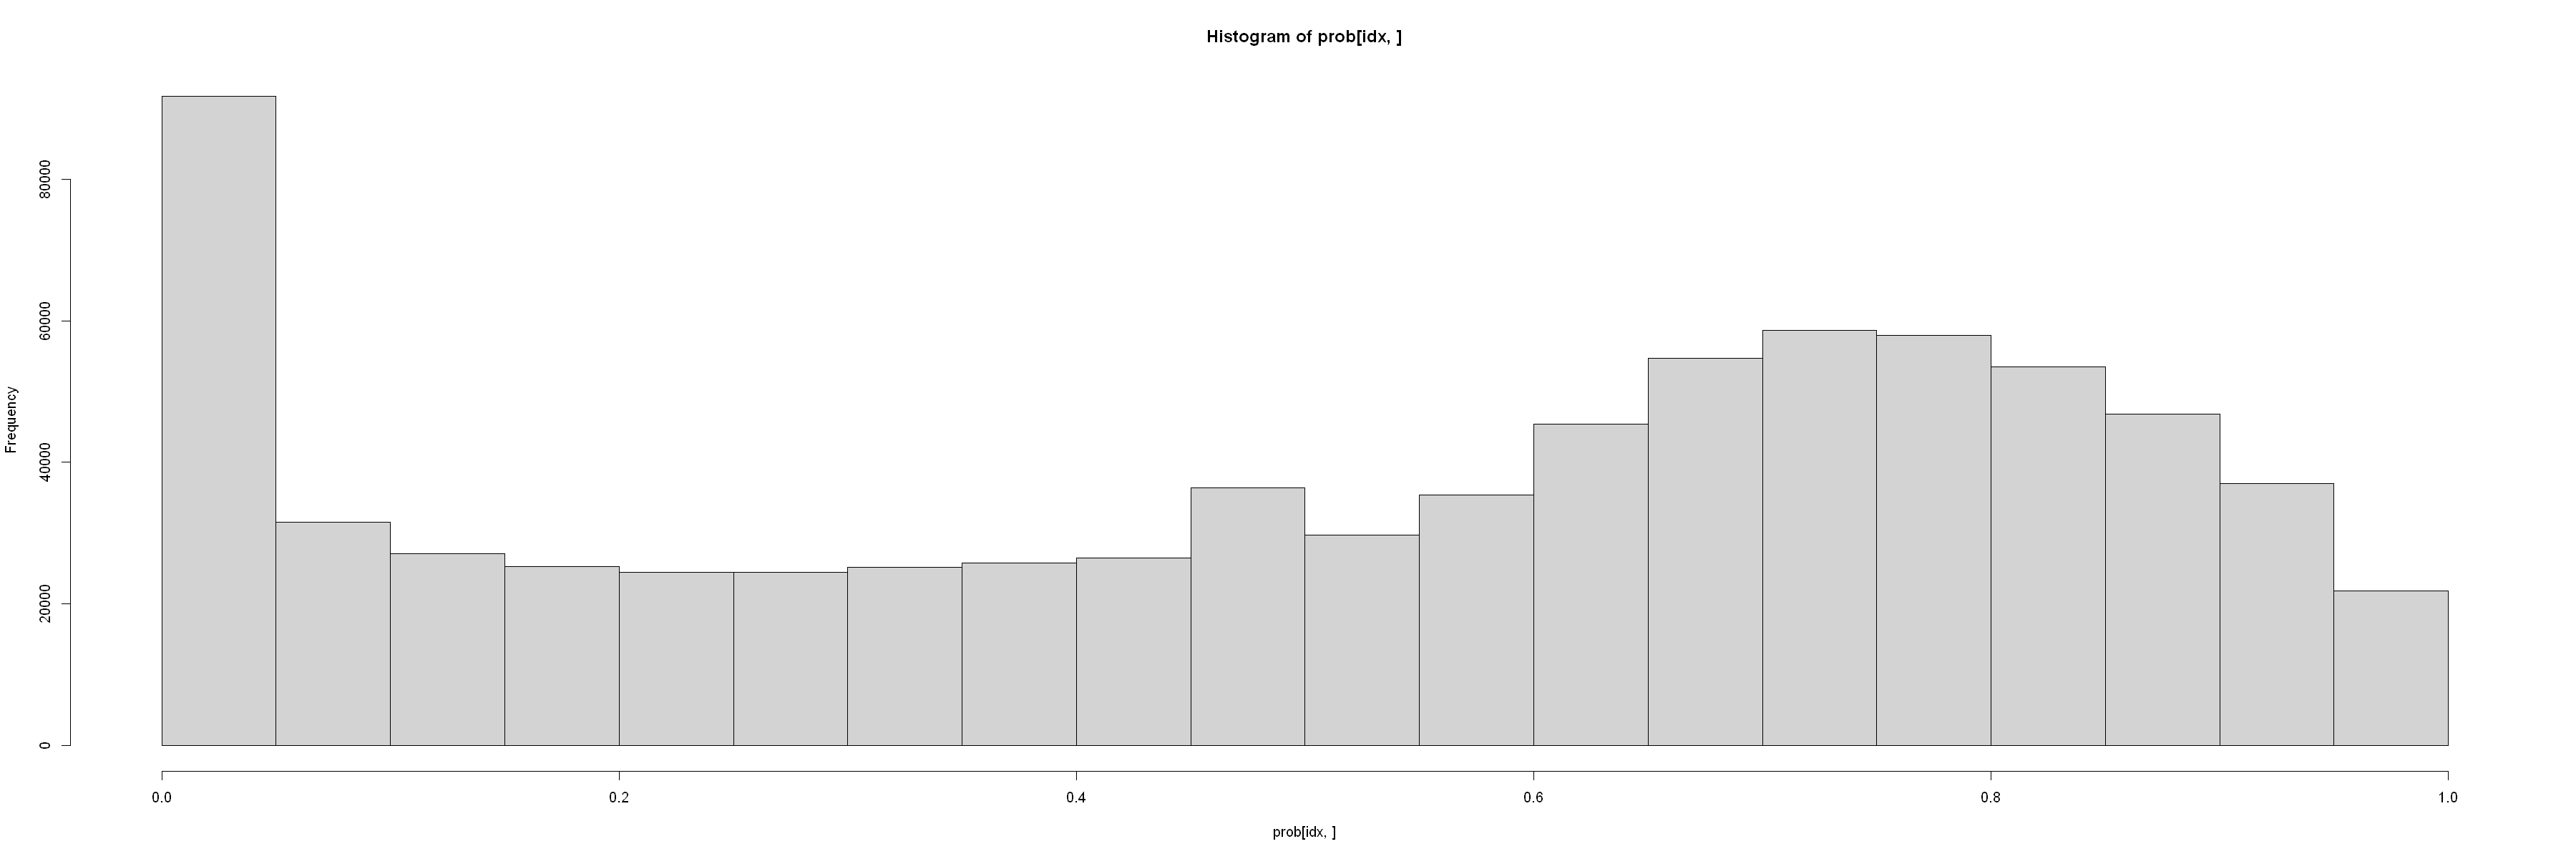

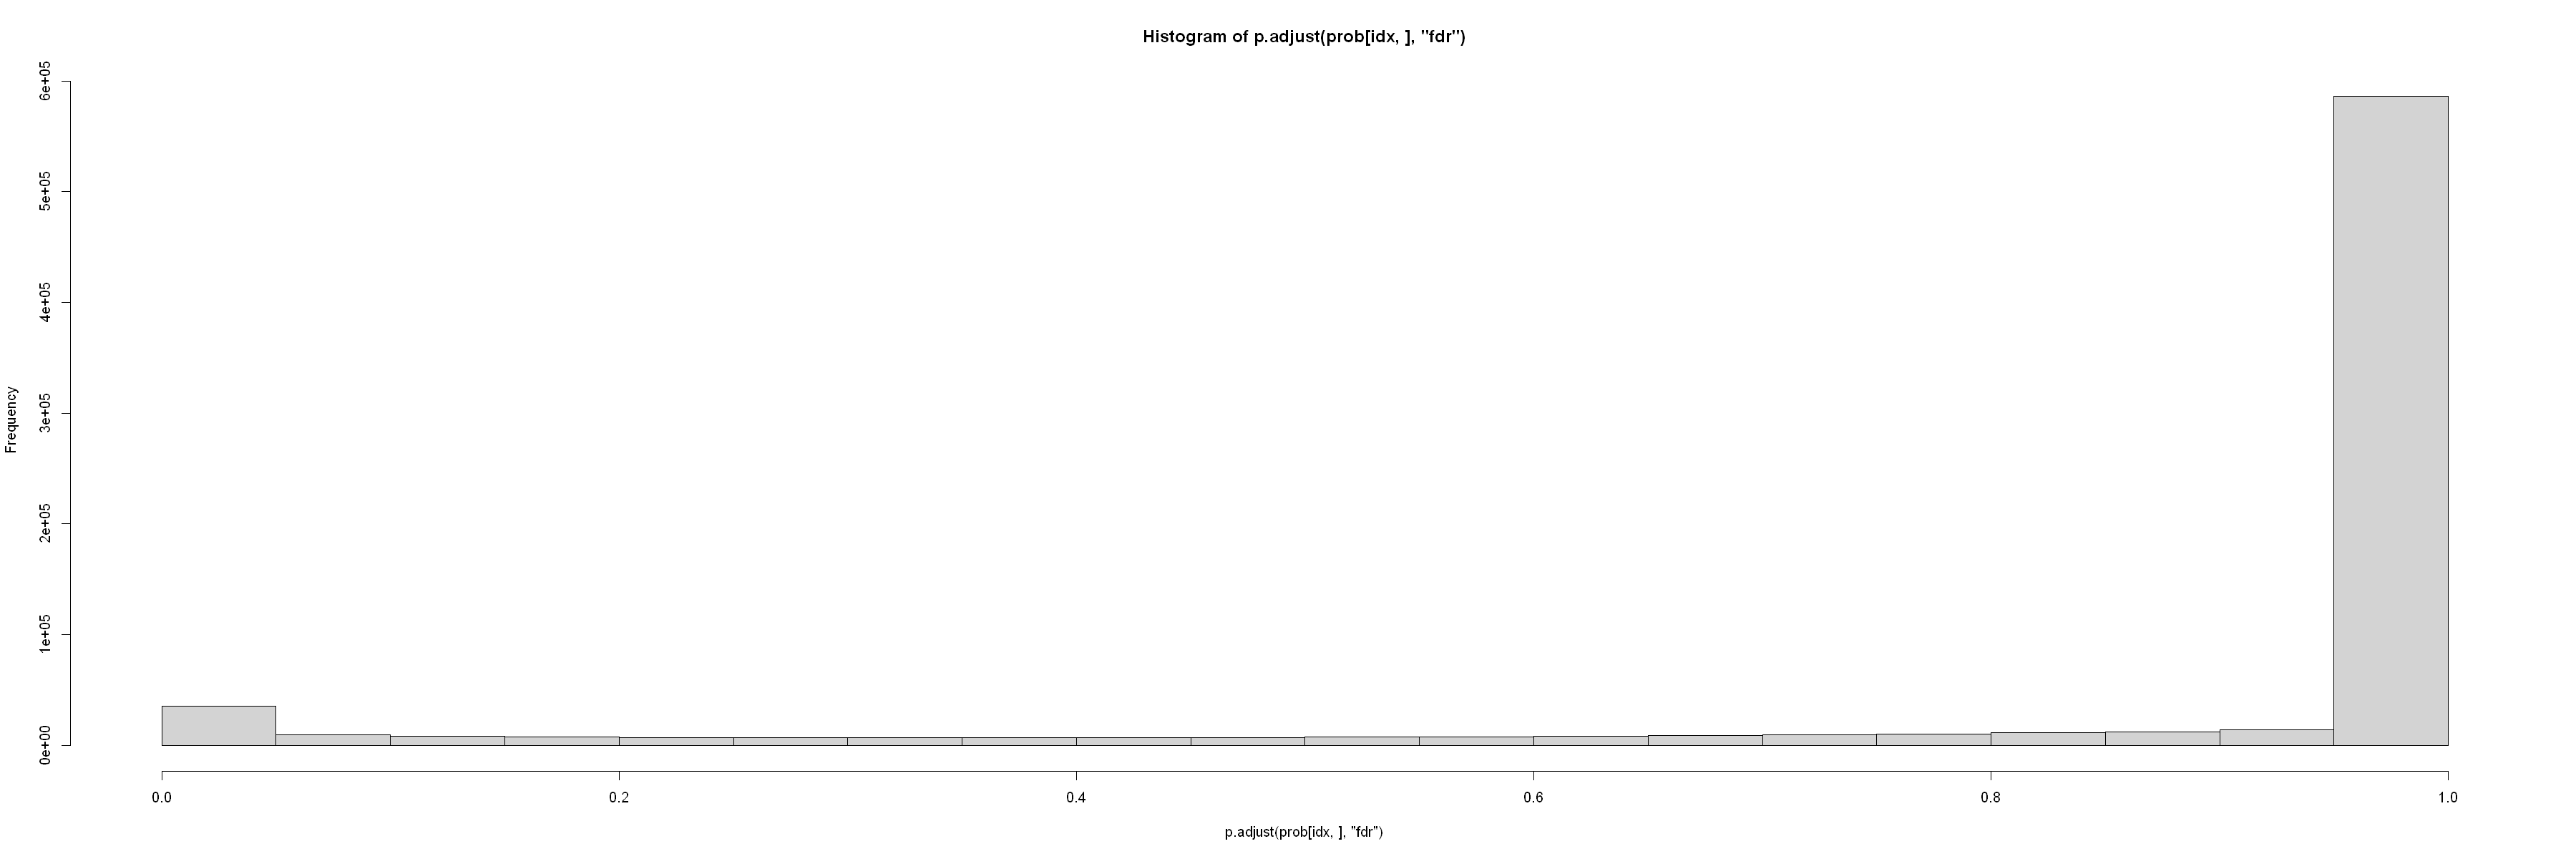

In [15]:
hist( prob[idx,])
hist( p.adjust(prob[idx,],'fdr'))


# count/cpm distributions

In [19]:
                    

experiment_group=phip_data@colData

if( multiple_plates ){
    run = factor(phip_data@colData$Plate)
    run2=(gsub('.*\\/fastq|\\/IDX.*','',phip_data@colData$fastq_filepath))
    phip_data@colData$plate2=run2
}else{
    phip_data@colData$Plate = 1
    phip_data@colData$Plate2= 1
}

In [20]:
# run

In [2]:
# table(run,run2)
# str(run)
# str(run2)

In [22]:
idx = sample( 1:nrow(phip_data), 1e4)


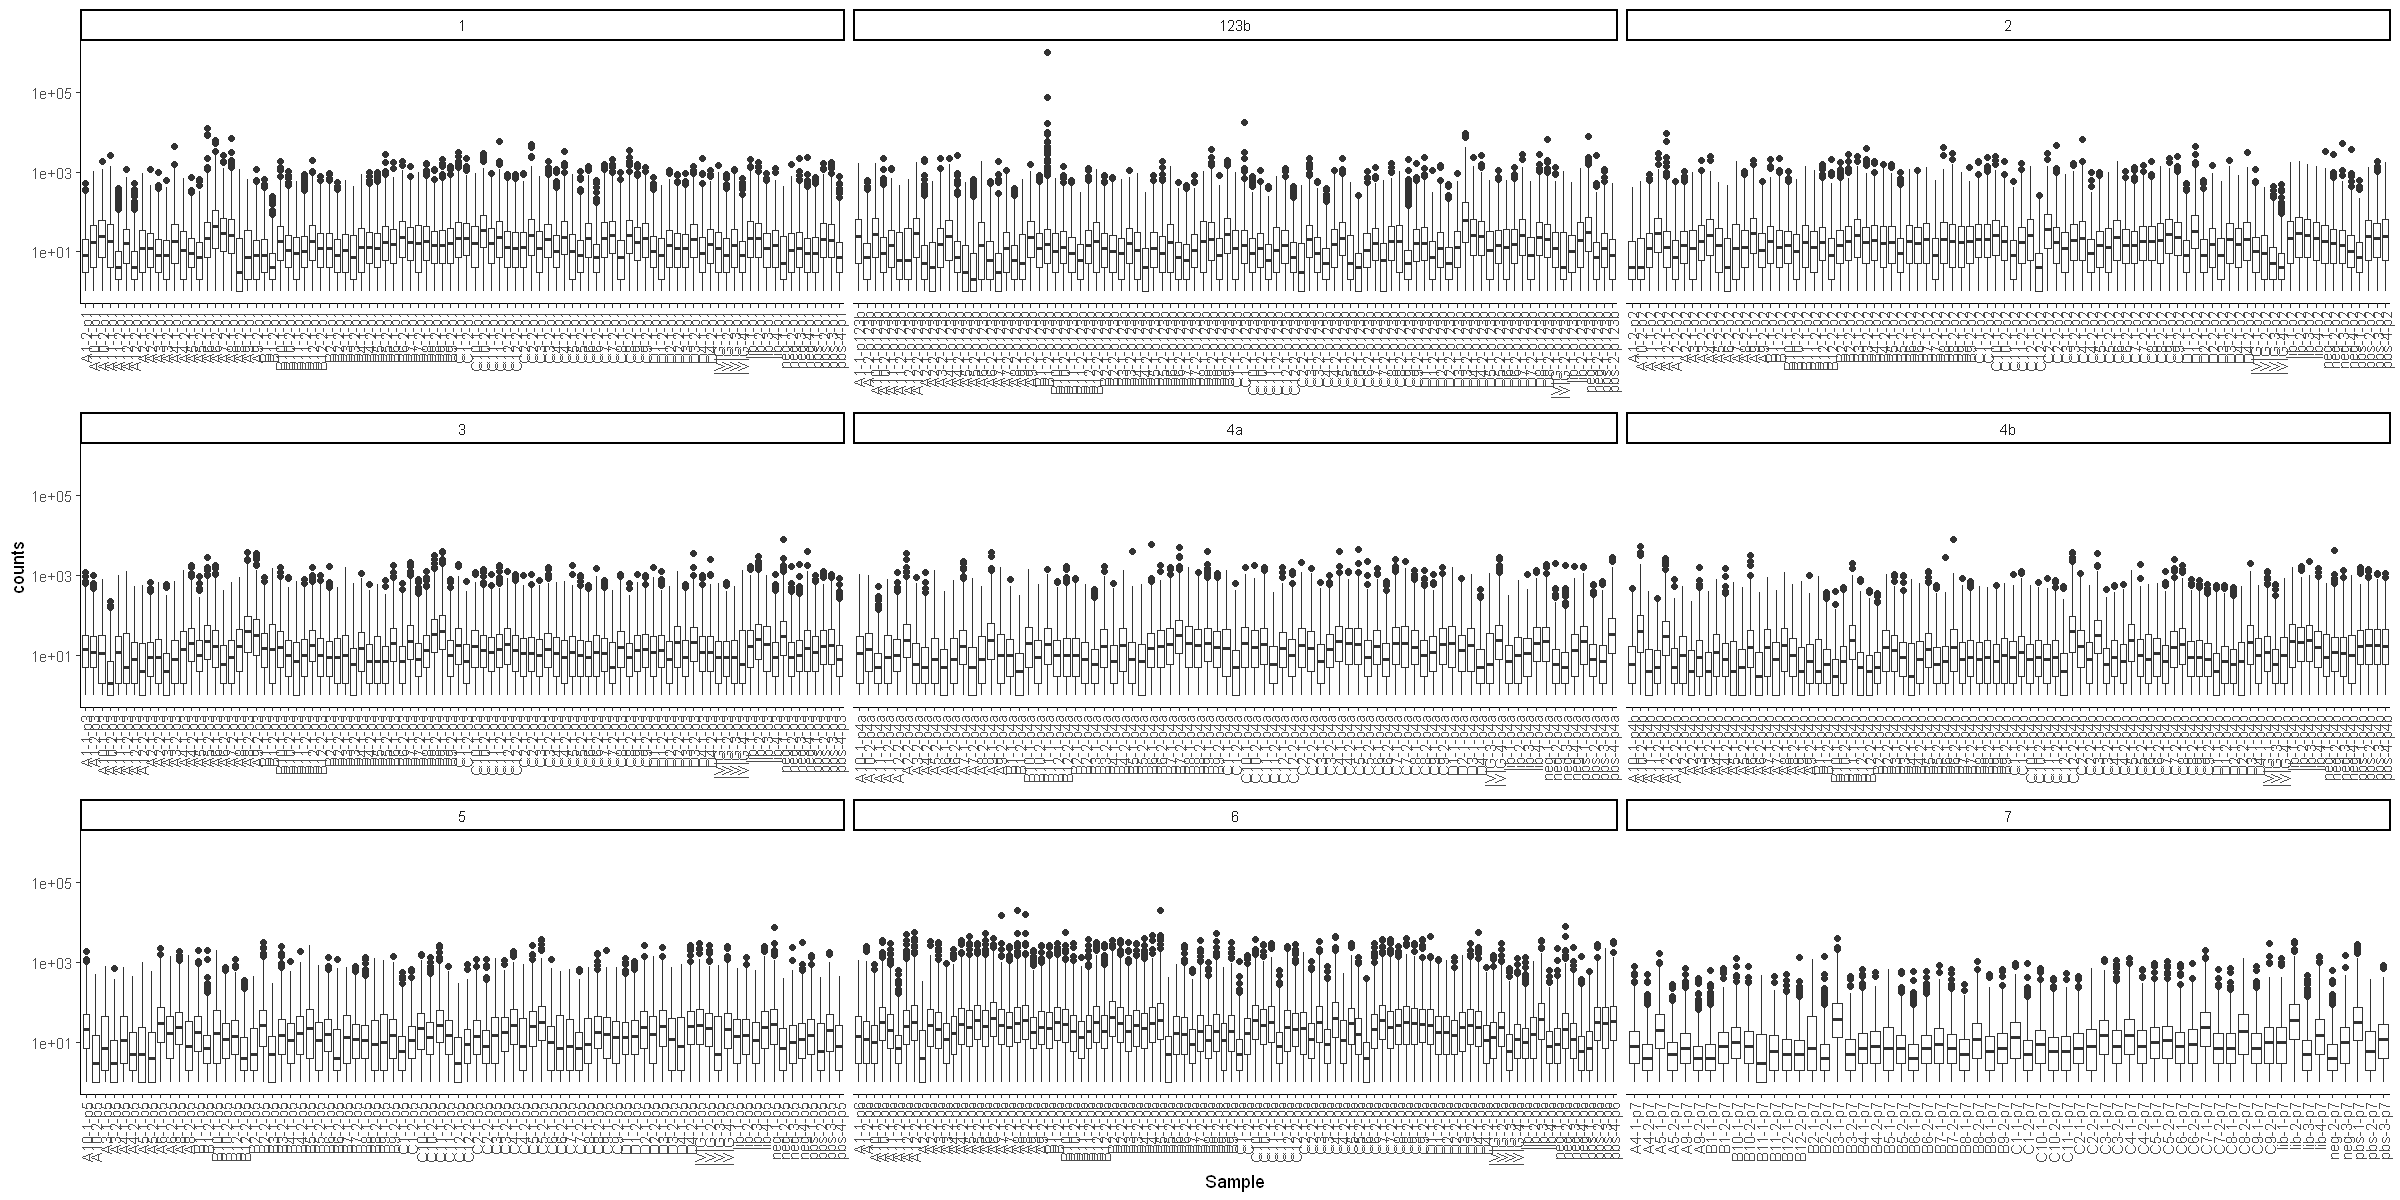

In [23]:
options( repr.plot.width=20,repr.plot.height=10)

stat='counts'
dat<-assays(phip_data)[[stat]][idx,]

dat%>%melt()%>%merge( cbind( Var2=1:ncol(dat) , run2=run2, sample=phip_data@colData$technical_replicate_id )) %>%
    ggplot(aes(x=sample,y=value+1))+
        geom_boxplot()+facet_wrap(~run2,scale='free_x')+scale_y_log10()+
        theme_classic()+xlab('Sample')+ylab('counts')+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave('../results/4_QC/4b.1_boxplots.counts.pdf',height=10,width=20)

In [24]:
# stat='counts'
cpm<-assays(phip_data)[['cpm']]
# cpm=apply( dat , 2 , function(x) (x/sum(x))*1e6)

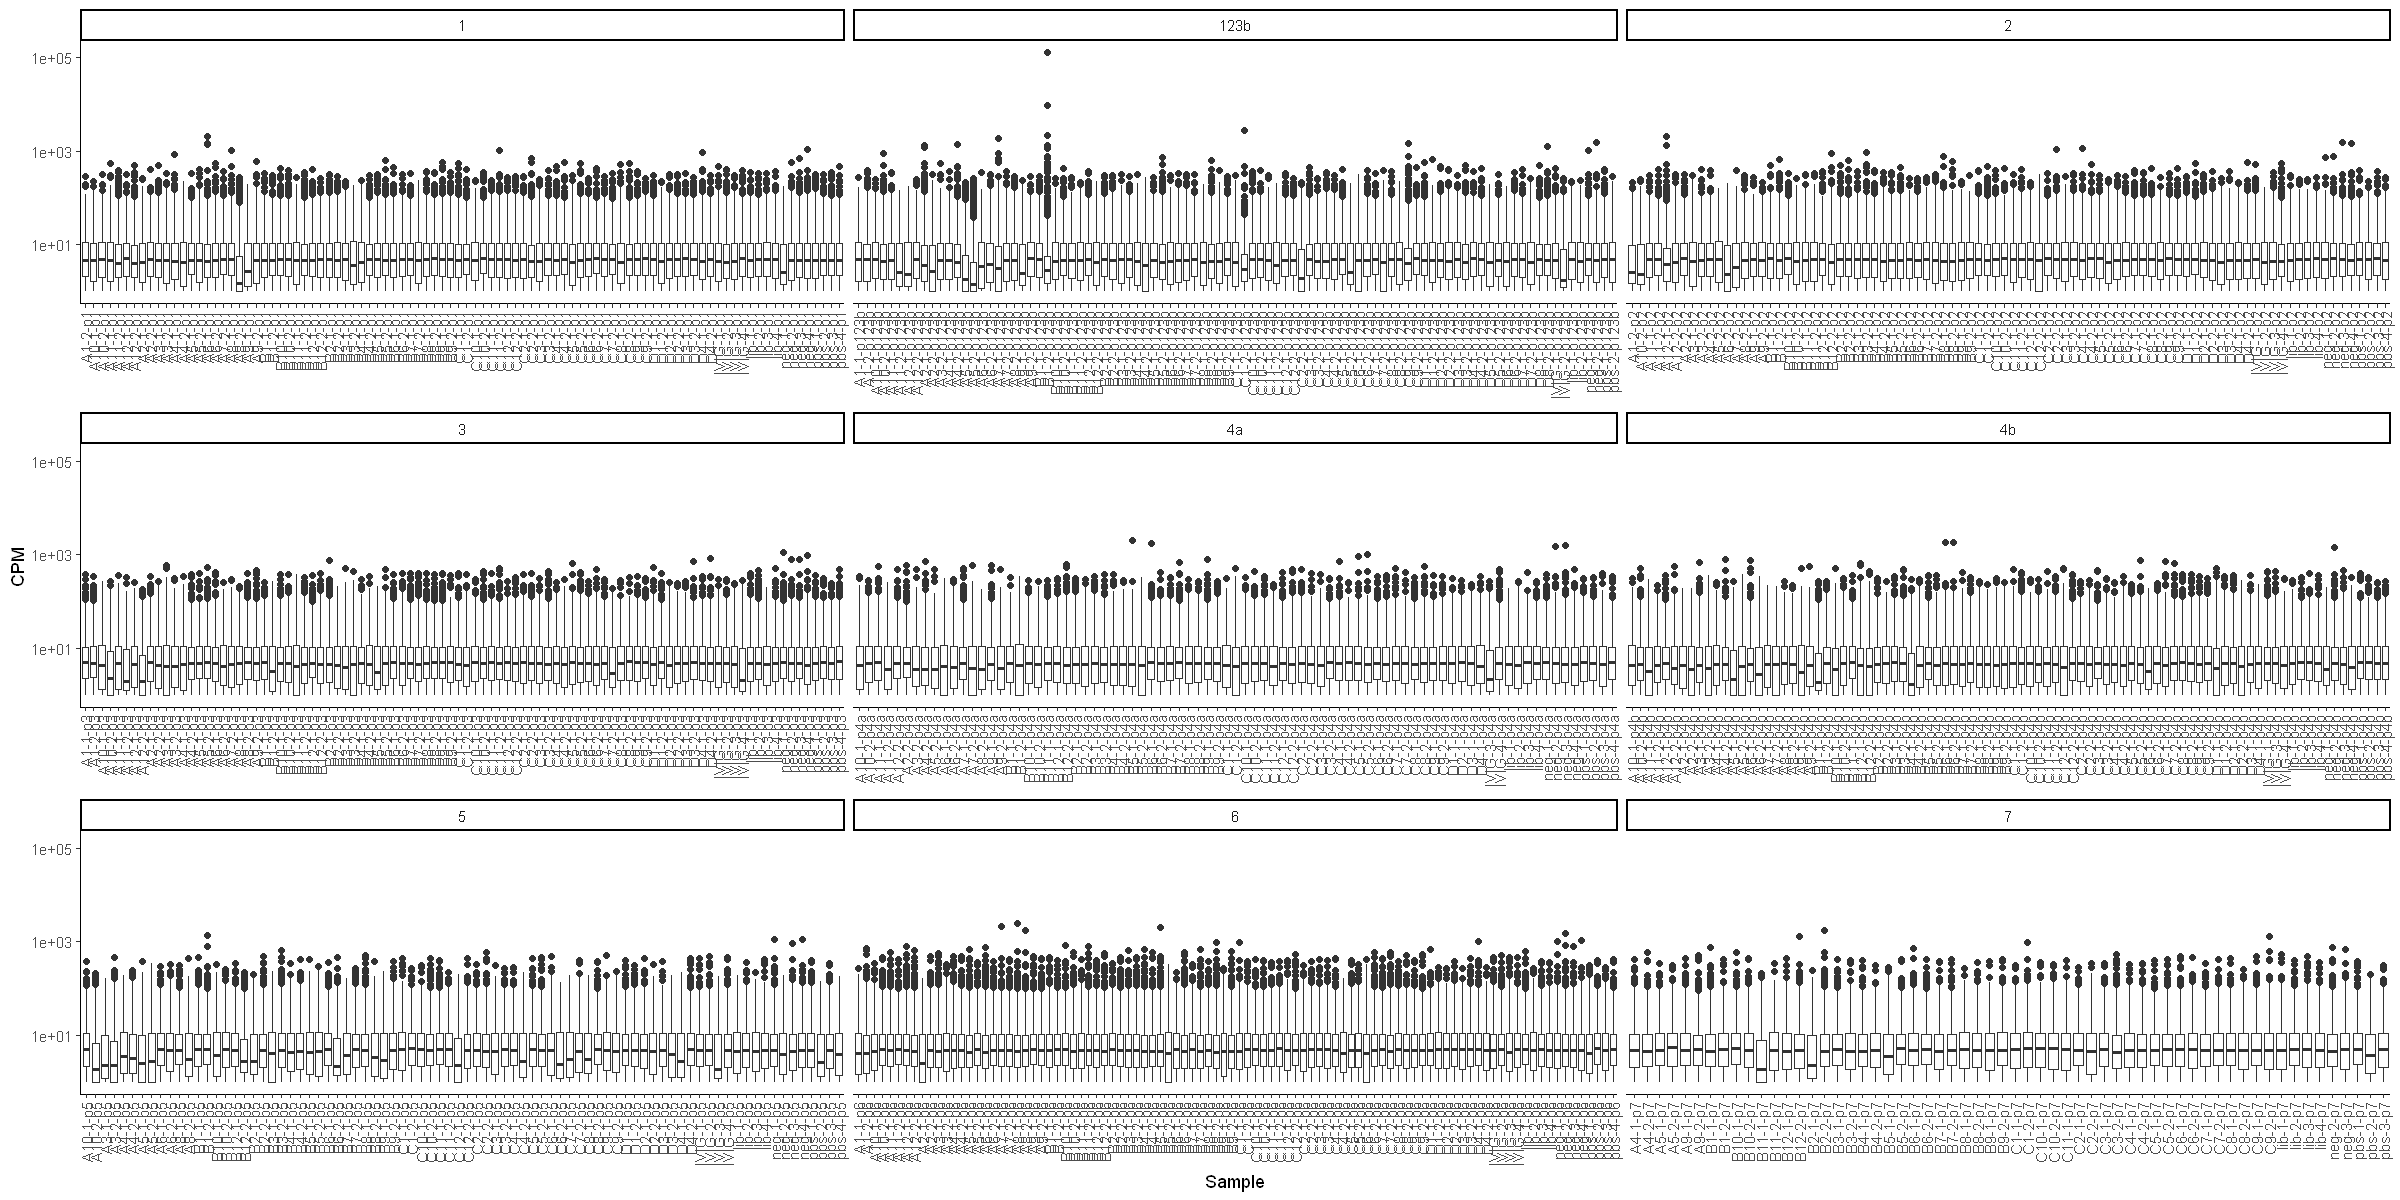

In [25]:
options( repr.plot.width=20,repr.plot.height=10)


cpm[idx,]%>%melt()%>%merge( cbind( Var2=1:ncol(dat) , run2=run2, sample=phip_data@colData$technical_replicate_id )) %>%
    ggplot(aes(x=sample,y=value+1))+
        geom_boxplot()+facet_wrap(~run2,scale='free_x')+scale_y_log10()+
        theme_classic()+xlab('Sample')+ylab('CPM')+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ggsave('../results/4_QC/4b.2_boxplots.cpm.pdf',height=10,width=20)

# sequencing and alignment stats

In [26]:
options( repr.plot.width=20,repr.plot.height=10)

cn = colnames(data.frame(phip_data@colData))
value.vars = c('raw_total_sequences','reads_mapped','error_rate','average_quality','percent_mapped','percent_peptides_detected','percent_peptides_between_10_and_100')
sdat = data.frame(phip_data@colData) %>% 
    melt( id.vars=cn[!cn%in%value.vars])

In [27]:
head(sdat)

,sample_id,sample_name,sample,Plate,index,Well.Position,technical_replicate_id,group,fastq_filepath,sample_ID,...,Birthweight.in.grams,GA.at.Delivery.,Pre.Pregnancy.BMI,Pre.Pregnancy.Obesity..BMI...30.,BMI.in.Preg,GA.at.BMI,Notes,plate2,variable,value
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,0,3001 MBPLAV1A1,E1-p123b,p123b,IDX049,E1,A1-2-p123b,trt,../data-raw/fastq123b/IDX049-A1-2_S49_R1_001.trim.fastq.gz,S49_123b,...,3460,37w0d,Unavailable,1,33.979999999999997,10w1d,no-val,123b,raw_total_sequences,1730895
2,1,3001 MBPLAV1A1,A10-p3,p3,IDX010,A10,A10-1-p3,trt,../data-raw/fastq3/IDX010-A10-1-p3_S10_R1_001.trim.fastq.gz,S10_3,...,3460,37w0d,Unavailable,1,33.979999999999997,10w1d,no-val,3,raw_total_sequences,1667026
3,2,3001 MBPLAV1A1,E10-p3,p3,IDX058,E10,A10-2-p3,trt,../data-raw/fastq3/IDX058-A10-2-p3_S58_R1_001.trim.fastq.gz,S58_3,...,3460,37w0d,Unavailable,1,33.979999999999997,10w1d,no-val,3,raw_total_sequences,3114780
4,3,3001 MBPLAV1A1,A1-p123b,p123b,IDX001,A1,A1-1-p123b,trt,../data-raw/fastq123b/IDX001-A1-1_S1_R1_001.trim.fastq.gz,S1_123b,...,3460,37w0d,Unavailable,1,33.979999999999997,10w1d,no-val,123b,raw_total_sequences,847805
5,4,3002 MBPLAV1A1,E12-p2,p2,IDX156,E12,A12-2-p2,trt,../data-raw/fastq2/IDX156-A12-2_S60_R1_001.trim.fastq.gz,S60_2,...,2280,37w4d,Unavailable,0,27.96,09w2d,no-val,2,raw_total_sequences,6285531
6,5,3002 MBPLAV1A1,A12-p2,p2,IDX108,A12,A12-1-p2,trt,../data-raw/fastq2/IDX108-A12-1_S12_R1_001.trim.fastq.gz,S12_2,...,2280,37w4d,Unavailable,0,27.96,09w2d,no-val,2,raw_total_sequences,1959374


In [28]:
with(data.frame(phip_data@colData),
   table( Plate,gsub('.*-','',sample_ID) )
)
with(data.frame(phip_data@colData),
   table( Plate,plate2 )
)
# sdat

       
Plate   S1_123b S1_3 S1_6 S10_1 S10_123b S10_3 S10_4b S10_5 S10_6 S102_4a
  p1          0    0    0     1        0     0      0     0     0       0
  p123b       1    0    0     0        1     0      0     0     0       0
  p2          0    0    0     0        0     0      0     0     0       0
  p3          0    1    0     0        0     1      0     0     0       0
  p4a         0    0    0     0        0     0      0     0     0       1
  p4b         0    0    0     0        0     0      1     0     0       0
  p5          0    0    0     0        0     0      0     1     0       0
  p6          0    0    1     0        0     0      0     0     1       0
  p7          0    0    0     0        0     0      0     0     0       0
       
Plate   S103_4a S105_4a S106_4a S107_4a S109_4a S11_1 S11_123b S11_2 S11_3
  p1          0       0       0       0       0     1        0     0     0
  p123b       0       0       0       0       0     0        1     0     0
  p2          0    

       plate2
Plate    1 123b  2  3 4a 4b  5  6  7
  p1    94    0  0  0  0  0  0  0  0
  p123b  0   93  0  0  0  0  0  0  0
  p2     0    0 88  0  0  0  0  0  0
  p3     0    0  0 94  0  0  0  0  0
  p4a    0    0  0  0 81  0  0  0  0
  p4b    0    0  0  0  0 90  0  0  0
  p5     0    0  0  0  0  0 82  0  0
  p6     0    0  0  0  0  0  0 96  0
  p7     0    0  0  0  0  0  0  0 61

# mockIP CPM

In [29]:
print(1)

[1] 1


In [30]:
options( repr.plot.width=20,repr.plot.height=10)



# dat_cpm=cpm # apply( assays(phip_data)[['counts']] , 2 , function(x) x/sum(x))*1e6
dat_cpm = assays(phip_data)[['cpm']]
colnames( dat_cpm)= paste(phip_data@colData$technical_replicate_id , phip_data@colData$plate2)
head(dat_cpm)



,A1-2-p123b 123b,A10-1-p3 3,A10-2-p3 3,A1-1-p123b 123b,A12-2-p2 2,A12-1-p2 2,C7-2-p1 1,C7-1-p1 1,A2-2-p123b 123b,A2-1-p123b 123b,...,C9-2-p6 6,C9-1-p6 6,C10-2-p6 6,C10-1-p6 6,C11-1-p6 6,C11-2-p6 6,C10-1-p7 7,C10-2-p7 7,C11-1-p7 7,C11-2-p7 7
0,1.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.84,0.00
1,2.42,3.77,5.67,0.00,2.15,1.61,3.18,2.64,1.13,0.55,...,6.30,1.95,3.90,1.02,1.14,1.26,1.80,0.52,7.52,1.56
2,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,...,0.12,0.28,0.00,0.00,1.25,0.00,1.80,0.00,0.00,2.33
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.48,0.00,1.20,0.00,0.00,0.78
4,1.21,5.02,0.00,1.24,1.49,0.00,3.86,1.65,2.46,0.00,...,2.47,4.88,3.09,0.73,2.50,9.46,2.99,9.79,1.67,5.44
5,0.00,3.77,0.33,1.24,1.99,1.07,1.36,1.15,0.76,0.00,...,3.58,2.09,1.75,1.16,1.48,10.21,2.99,2.58,1.67,1.56


In [31]:

cpm_b = dat_cpm[,phip_data@colData$group=='beads']


md=median(cpm_b)
#md=mean(apply(cpm_b,2,function(x) mode(na.omit(x))))
dfs=data.frame(
 perc_lib_detected = sum(rowMeans(cpm_b)>0) / nrow(dat_cpm),
 perc_within_1log = sum(apply(cpm_b,1,function(x) any( (log(x)<log(md)+1) & (log(x)>log(md)-1) ))) / nrow(dat_cpm)
)

In [32]:
dfs

perc_lib_detected,perc_within_1log
<dbl>,<dbl>
0.994971,0.9202071


Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 469354 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 469354 rows containing non-finite outside the scale range (`stat_bin()`)."


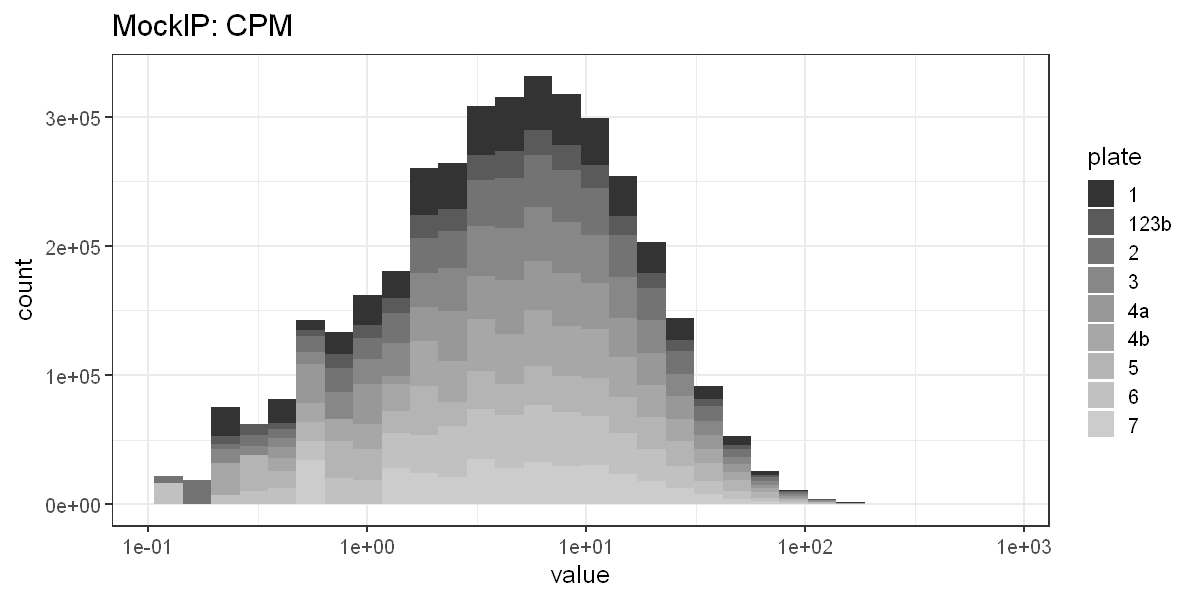

In [33]:

options( repr.plot.width=10,repr.plot.height=5)

reshape2::melt(cpm_b) %>% 
mutate(plate=gsub('.* ','',Var2))%>%
ggplot(aes(x=value,fill=plate))+
    geom_histogram()+scale_x_log10() +#facet_wrap(~plate)+
    scale_fill_grey()+
    ggtitle('MockIP: CPM')+theme_bw(base_size = 15)


ggsave('../results/4_QC/4b.3_mockIP.distr.pdf',height=10,width=20)

In [34]:
dim(cpm_b)

[1] 128257     33

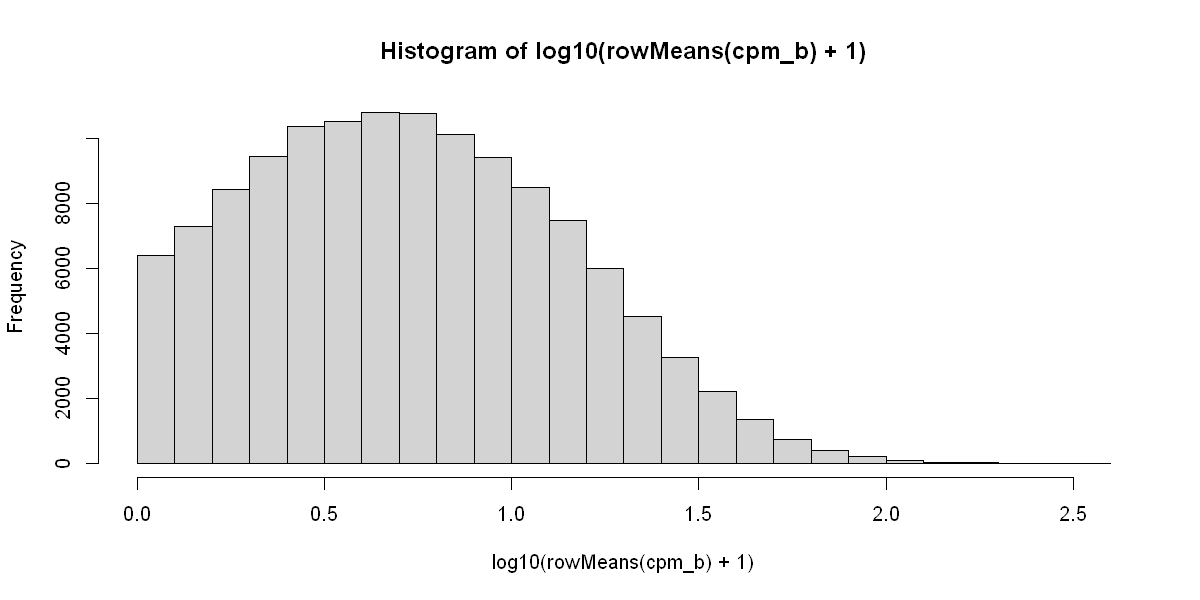

In [35]:
hist(log10(rowMeans(cpm_b)+1))


Warning message:
"Removed 1558 rows containing missing values or values outside the scale range (`geom_hline()`)."
Warning message:
"Removed 1558 rows containing missing values or values outside the scale range (`geom_hline()`)."


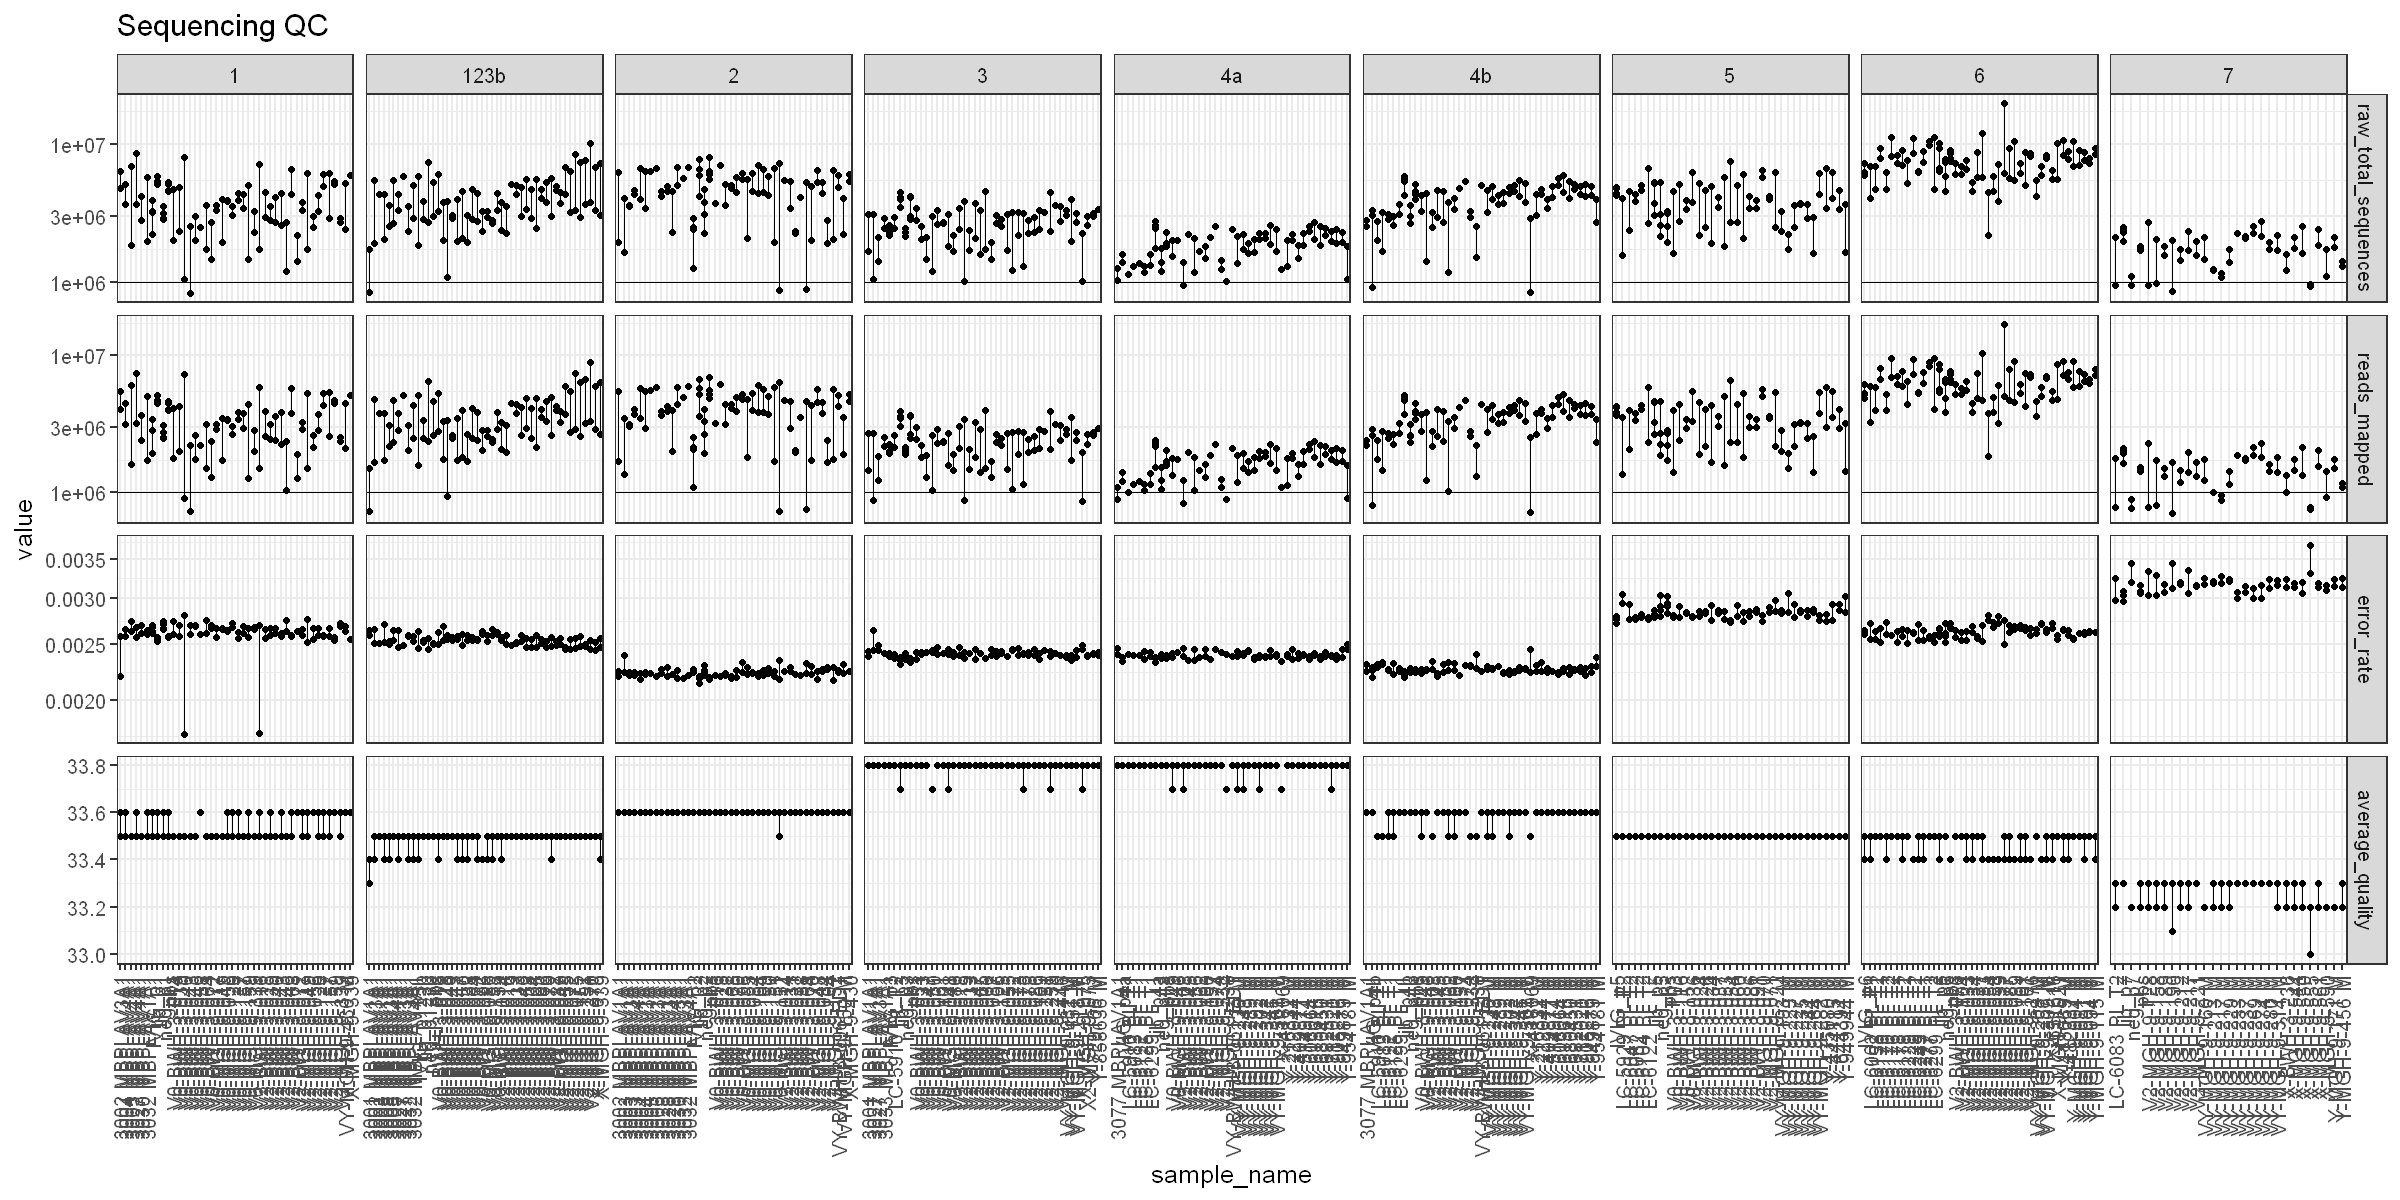

In [36]:
options( repr.plot.width=20,repr.plot.height=10)

# head(sdat)

sdat %>% filter( variable %in% c('raw_total_sequences','reads_mapped','error_rate','average_quality')) %>%
    ggplot( aes( x=sample_name , y=value ))+
        geom_point()+geom_line(aes(group=sample_name))+
        geom_hline(aes(yintercept = ifelse( variable %in% c('raw_total_sequences','reads_mapped'),1e6,NA)))+
        facet_grid(variable~plate2,scale='free')+scale_y_log10()+
        theme_bw(base_size=15) + ggtitle('Sequencing QC')+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggsave(filename = '../results/4_QC/4b.4_sequencing_QC.pdf',height=10,width=20)



Warning message:
"Removed 1558 rows containing missing values or values outside the scale range (`geom_hline()`)."
Warning message:
"Removed 1558 rows containing missing values or values outside the scale range (`geom_hline()`)."


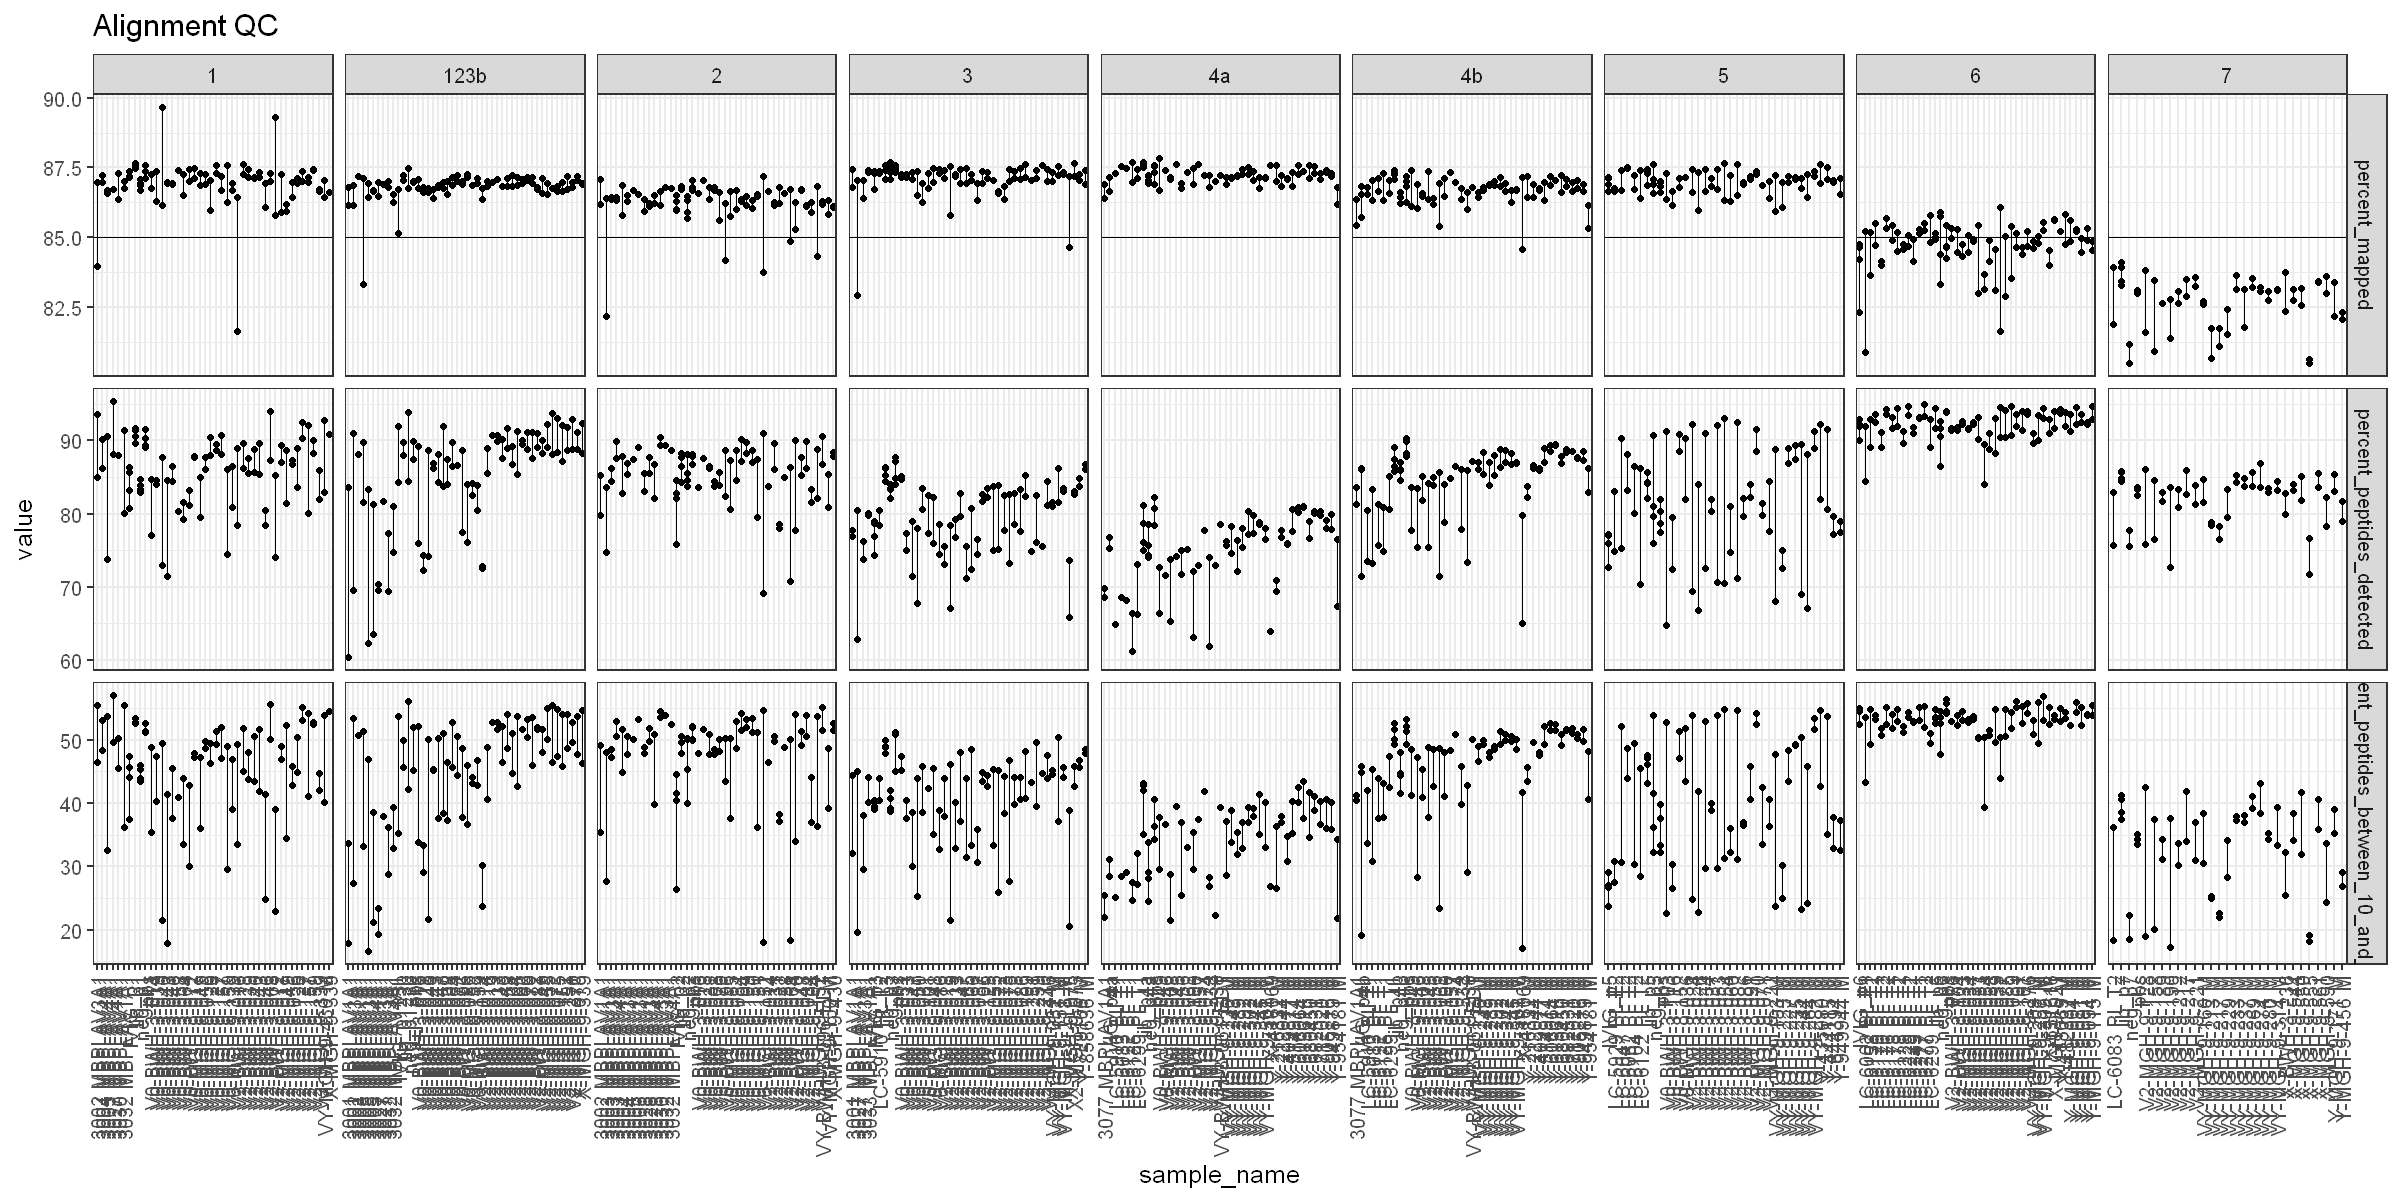

In [37]:
sdat %>% filter( variable %in% c('percent_mapped','percent_peptides_detected','percent_peptides_between_10_and_100')) %>%
    ggplot( aes( x=sample_name , y=value ))+
        geom_point()+geom_line(aes(group=sample_name))+
        geom_hline(aes(yintercept = ifelse( variable =='percent_mapped',85,NA)))+
        # geom_hline(aes(yintercept = ifelse( variable =='percent_peptides_detected',90,NA)))+
        # geom_hline(aes(yintercept = ifelse( variable =='percent_peptides_between_10_and_100',50,NA)))+
        facet_grid(variable~plate2,scale='free')+
        theme_bw(base_size=15)+ ggtitle('Alignment QC')+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
        
ggsave(filename = '../results/4_QC/4b.5_alignment_QC.pdf',height=10,width=20)

## Sample check

In [38]:
value.vars = c('raw_total_sequences','reads_mapped','error_rate','average_quality','percent_mapped','percent_peptides_detected','percent_peptides_between_10_and_100')

data.frame(phip_data@colData) %>%
    # group_by(sample_ID) %>%
    summarize_at((value.vars),quantile,probs=c(.25,.5,.75),na.rm=T)

# data.frame(phip_data@colData)$raw_total_sequences<1e6
# data.frame(phip_data@colData)$percent_mapped<85
check = data.frame(phip_data@colData) %>% #filter( plate!=4 ) %>%
    group_by(sample_ID) %>%
        summarize(
            raw_total_sequences = sum(raw_total_sequences<1e6),
            percent_mapped = sum(percent_mapped<85),
            percent_peptides_detected=sum(percent_peptides_detected<75),
            percent_peptides_between_10_and_100=sum(percent_peptides_between_10_and_100<35)
        )
# check

check %>% summarize(sum(!(raw_total_sequences==0 & percent_mapped==0  & percent_peptides_between_10_and_100==0)))
check %>% filter((!(raw_total_sequences==0 & percent_mapped==0  & percent_peptides_between_10_and_100==0)))


omit=check %>% filter(!(raw_total_sequences==0 & percent_mapped==0  & percent_peptides_between_10_and_100==0)) %>% select(sample_ID) %>% unlist()
paste(omit,collapse='","')

Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
i Please use `reframe()` instead.
i When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame
  and adjust accordingly.
i The deprecated feature was likely used in the dplyr package.
  Please report the issue at <https://github.com/tidyverse/dplyr/issues>."


raw_total_sequences,reads_mapped,error_rate,average_quality,percent_mapped,percent_peptides_detected,percent_peptides_between_10_and_100
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2250889,1941493,0.002353043,33.5,86.07039,79.30639,37.14066
3367970,2923749,0.002513684,33.5,86.79869,84.52170,45.29343
5063185,4389045,0.002663266,33.6,87.15256,88.81776,51.03386


sum(...)
<int>
242


sample_ID,raw_total_sequences,percent_mapped,percent_peptides_detected,percent_peptides_between_10_and_100
<chr>,<int>,<int>,<int>,<int>
S102_4a,0,0,1,1
S103_4a,0,0,1,1
S105_4a,0,0,1,1
S106_4a,0,0,1,1
S107_4a,0,0,1,1
S109_4a,1,0,1,1
S10_123b,0,0,1,1
S10_3,0,0,0,1
S10_5,0,0,1,1


[1] "S102_4a\",\"S103_4a\",\"S105_4a\",\"S106_4a\",\"S107_4a\",\"S109_4a\",\"S10_123b\",\"S10_3\",\"S10_5\",\"S10_6\",\"S11_123b\",\"S11_2\",\"S11_6\",\"S120_4a\",\"S121_4a\",\"S123_4a\",\"S127_4a\",\"S12_1\",\"S12_123b\",\"S12_3\",\"S12_4b\",\"S12_6\",\"S132_4a\",\"S133_4a\",\"S13_1\",\"S13_123b\",\"S13_2\",\"S13_3\",\"S13_5\",\"S13_6\",\"S13_7\",\"S144_4a\",\"S146_4a\",\"S147_4a\",\"S148_4a\",\"S149_4a\",\"S14_7\",\"S150_4a\",\"S154_4a\",\"S155_4a\",\"S156_4a\",\"S157_4a\",\"S158_4a\",\"S159_4a\",\"S15_1\",\"S15_3\",\"S15_6\",\"S15_7\",\"S160_4a\",\"S161_4a\",\"S162_4a\",\"S166_4a\",\"S168_4a\",\"S16_6\",\"S16_7\",\"S171_4a\",\"S17_3\",\"S17_5\",\"S17_7\",\"S180_4a\",\"S187_4a\",\"S188_4a\",\"S189_4a\",\"S18_3\",\"S18_5\",\"S18_6\",\"S18_7\",\"S190_4a\",\"S191_4a\",\"S192_4a\",\"S19_5\",\"S19_6\",\"S19_7\",\"S1_123b\",\"S1_3\",\"S1_6\",\"S20_3\",\"S20_6\",\"S20_7\",\"S21_5\",\"S21_6\",\"S21_7\",\"S22_2\",\"S22_6\",\"S22_7\",\"S23_6\",\"S23_7\",\"S24_1\",\"S24_123b\",\"S24_5\",\"S24_7\",\"S25_2\",\"S25_6\",\"S25_7\",\"S26_7\",\"S27_7\",\"S28_7\",\"S29_6\",\"S29_7\",\"S2_1\",\"S2_123b\",\"S2_3\",\"S2_4b\",\"S2_6\",\"S30_5\",\"S30_7\",\"S31_5\",\"S31_6\",\"S31_7\",\"S32_7\",\"S33_6\",\"S33_7\",\"S34_7\",\"S35_6\",\"S35_7\",\"S36_6\",\"S37_6\",\"S38_6\",\"S39_6\",\"S3_2\",\"S3_4b\",\"S3_5\",\"S3_6\",\"S41_6\",\"S41_7\",\"S42_7\",\"S43_6\",\"S43_7\",\"S44_7\",\"S45_6\",\"S45_7\",\"S46_7\",\"S47_5\",\"S47_6\",\"S47_7\",\"S48_5\",\"S48_6\",\"S49_123b\",\"S4_1\",\"S4_123b\",\"S4_3\",\"S4_4b\",\"S4_5\",\"S4_6\",\"S4_7\",\"S52_7\",\"S53_1\",\"S53_7\",\"S54_6\",\"S55_123b\",\"S55_6\",\"S57_6\",\"S57_7\",\"S59_6\",\"S5_1\",\"S5_123b\",\"S5_3\",\"S5_5\",\"S5_6\",\"S5_7\",\"S60_123b\",\"S61_5\",\"S61_6\",\"S61_7\",\"S62_5\",\"S62_7\",\"S63_7\",\"S64_5\",\"S64_7\",\"S65_7\",\"S66_5\",\"S66_7\",\"S67_7\",\"S68_7\",\"S69_7\",\"S6_1\",\"S6_123b\",\"S6_3\",\"S6_5\",\"S6_6\",\"S70_7\",\"S71_6\",\"S71_7\",\"S72_123b\",\"S72_5\",\"S72_6\",\"S72_7\",\"S73_1\",\"S73_3\",\"S73_6\",\"S73_7\",\"S74_6\",\"S74_7\",\"S75_7\",\"S76_7\",\"S77_7\",\"S78_7\",\"S79_1\",\"S79_7\",\"S7_123b\",\"S7_6\",\"S80_7\",\"S81_6\",\"S81_7\",\"S82_5\",\"S82_6\",\"S82_7\",\"S83_5\",\"S83_6\",\"S83_7\",\"S84_5\",\"S84_6\",\"S85_3\",\"S85_4b\",\"S85_6\",\"S86_4b\",\"S86_6\",\"S87_6\",\"S88_3\",\"S88_5\",\"S88_6\",\"S89_4b\",\"S89_5\",\"S89_6\",\"S8_1\",\"S8_5\",\"S90_5\",\"S90_6\",\"S91_5\",\"S91_6\",\"S92_2\",\"S92_5\",\"S92_6\",\"S94_5\",\"S94_7\",\"S95_6\",\"S95_7\",\"S96_6\",\"S9_123b\",\"S9_2\",\"S9_6\",\"S9_7"

In [39]:
# value.vars = c('raw_total_sequences','reads_mapped','error_rate','average_quality','percent_mapped','percent_peptides_detected','percent_peptides_between_10_and_100')

# data.frame(phip_data@colData) %>%
#     # group_by(sample_ID) %>%
#     summarize_at((value.vars),quantile,probs=c(.25,.5,.75),na.rm=T)

# # data.frame(phip_data@colData)$raw_total_sequences<1e6
# # data.frame(phip_data@colData)$percent_mapped<85
# check = data.frame(phip_data@colData) %>% filter( Plate!=4 ) %>%
#     group_by(sample_ID) %>%
#         summarize(
#             raw_total_sequences = sum(raw_total_sequences<1e6),
#             percent_mapped = sum(percent_mapped<85),
#             percent_peptides_detected=sum(percent_peptides_detected<75),
#             percent_peptides_between_10_and_100=sum(percent_peptides_between_10_and_100<35)
#         )
# # check

# check %>% summarize(sum(!(raw_total_sequences==0 & percent_mapped==0  & percent_peptides_between_10_and_100==0)))
# check %>% filter((!(raw_total_sequences==0 & percent_mapped==0  & percent_peptides_between_10_and_100==0)))


# omit=check %>% filter(!(raw_total_sequences==0 & percent_mapped==0  & percent_peptides_between_10_and_100==0)) %>% select(sample_ID) %>% unlist()
# paste(omit,collapse='","')

In [40]:
# unblind = read.csv('../data-final/unblind.csv',row.names=1)
# head(unblind)

In [41]:
# rerun=unblind %>% filter(sample%in%omit)%>%arrange(sample)
# head(rerun)
# write.csv(rerun,'../data-final/20240702_rerun.csv')

In [43]:
# phip_data

# saveRDS(phip_data,"../data-final/virscan_momi_all_2024-10-22//rds_data/PhIPData.annot.rds")
saveRDS(phip_data,paste0(base_dir,"rds_data/PhIPData.annot.rds"))
# phip_data <- readRDS(paste0(base_dir,"rds_data/PhIPData.rds"))


In [32]:

# library(viridis)

# phip_data <- read.table(
#       "results/tall_data/data-tall.csv", # gunzip first
#       header=TRUE, sep= ","
#   ) %>%
#   filter(Protein == "spike") %>%
#   filter(Virus == "SARSCoV2")

# # Plot
# p <- phip_data %>%
# ggplot(aes(
#       x=Prot_Start, y=counts,
#       group=factor(sample_id),
#       color=factor(patient_status))
#   ) +
#   theme_bw() +
#   geom_line() +
#   ggtitle("Sars-CoV-2 Spike Protein Enrichments") +
#   labs(y="# peptide alignments", x="Locus", color="infection status")